In [1]:
import yaml

# Path to your YAML file
input_file_path = "outputs/2025-06-06/cedar_gemini_clean_entity_type_map.yaml"

# Load the YAML content
with open(input_file_path, "r") as file:
    loaded_data = yaml.safe_load(file)

# Now `loaded_data` is a Python dictionary
print(loaded_data.keys())  # For example, show the top-level URLs

dict_keys(['https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002', 'https://lpdaac.usgs.gov/products/mod09a1v061/', 'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en', 'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en', 'https://zenodo.org/records/8319440', 'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz', 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e', 'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7', 'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e', 'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5', 'https://zenodo.org/records/11440456', 'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json', 'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g', 'https://datahuiswadden.openearth.nl/

In [10]:
url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forest reserves database and network (DANS)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans 2024 (Datahuis Wadden)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Actual probability distribution for Quercus robur (EcoDataCube)',    
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly blue band (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly green band (EcoDataCube)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Cloud-free reconstructed Landsat bimonthly NDVI (EcoDataCube)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird observation dataset (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Waterleidingduinen camera trap P2 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 land use scenarios for Belgium (Zenodo)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'Harmonized Landsat Sentinel-2 (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS Terra MOD09A1 Version 6.1 (LP DAAC)',   
    }

# preferred_order = ['Dutch forest reserves database and network', 'Ecotopenkaart 2016',
#        'Ecotopenkaart 2017', 'Waddenbalans 2024',
#        'Actual probability distribution for Quercus robur',
#        'Cloud-free reconstructed Landsat bimonthly NDVI',
#        'Cloud-free reconstructed Landsat yearly blue band',
#        'Cloud-free reconstructed Landsat yearly green band',
#        'Waterleidingduinen camera trap P1',
#        'Waterleidingduinen camera trap P2',
#        'Waterleidingduinen camera trap P3', 'eBird observation dataset',
#        'Harmonized Landsat Sentinel-2', 'MODIS Terra MOD09A1 Version 6.1',
#        'Downscaled LUH2 land use scenarios for Belgium',
#        'Waterleidingduinen camera trap P1-3']

In [2]:
list(loaded_data.keys())[11]

'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json'

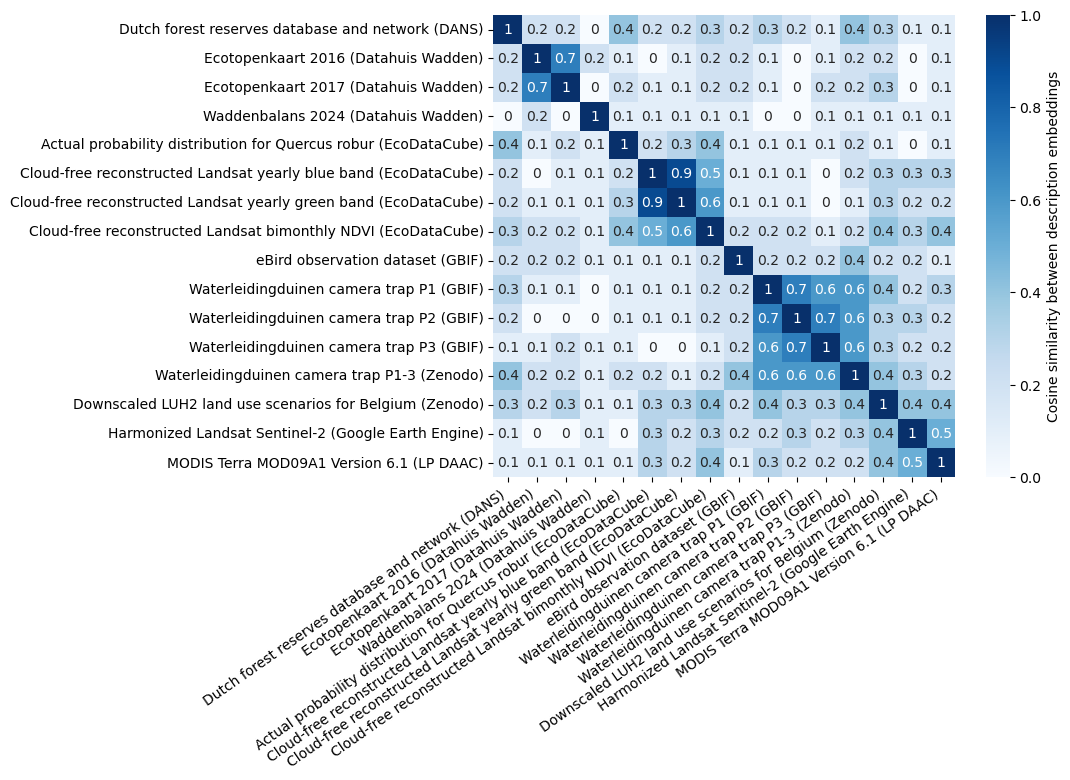

In [53]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

remove_upper_triangle = False
save_fig = True

concerned_attributes = ["Description"]
embedding_list = []
list_names =  []
for i_attr, attr in enumerate(concerned_attributes):
    value_list = []
    # for url, metadata_dict in loaded_data.items():
    for url, _ in url_to_ds_name.items():
        metadata_dict = loaded_data[url]
        if i_attr == 0:
            list_names.append(url_to_ds_name[url])
        if attr in metadata_dict:
            # Append the value of the concerned attribute to the list
            value_list.append(metadata_dict[attr][0])
        else:
            # If the attribute is not present, append a placeholder or default value
            random_text = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
            value_list.append(random_text)

    # Load a pretrained model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and effective

    # Encode texts to get embeddings
    embeddings = model.encode(value_list)
    embedding_list.append(embeddings)


concatenated = np.concatenate([embedding_list[0]], axis=1)
# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(concatenated)
cos_sim_matrix = np.round(cos_sim_matrix.astype(np.float64), 1)
cos_sim_matrix[np.where(cos_sim_matrix == 0)] = 0  # get rid of -0.0 rounding issues

concerned_attributes_string = "&".join(concerned_attributes)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
if remove_upper_triangle:
    # Set upper triangle to NaN
    mask = np.triu(np.ones_like(cos_sim_matrix, dtype=bool), k=0)
    cos_sim_matrix[mask] = np.nan
    sns.heatmap(cos_sim_matrix[1:, :-1], annot=True, xticklabels=range(len(value_list) - 1), yticklabels=range(len(value_list) - 1), 
                ax=ax, cmap=sns.color_palette("Blues", as_cmap=True), square=True, cbar_kws={'label': 'Cosine Similarity'})
    ax.set_xticklabels(list_names[:-1], rotation=35, ha='right')
    ax.set_yticklabels(list_names[1:], rotation=0, ha='right')
else:
    sns.heatmap(cos_sim_matrix, annot=True, xticklabels=range(len(value_list)), yticklabels=range(len(value_list)), 
                ax=ax, cmap=sns.color_palette("Blues", as_cmap=True), square=True, cbar_kws={'label': 'Cosine similarity between description embeddings'})
    ax.set_xticklabels(list_names, rotation=35, ha='right')
    ax.set_yticklabels(list_names, rotation=0, ha='right')
# ax.set_title("Cosine Similarity Between Datasets:" + " " + concerned_attributes_string)

if save_fig:
    fig.savefig(f"figs/cosine_similarity_{concerned_attributes_string}.pdf", bbox_inches='tight')

In [50]:
cos_sim_matrix[np.where(cos_sim_matrix == 0)] = 0 
cos_sim_matrix

array([[1. , 0.2, 0.2, 0. , 0.4, 0.2, 0.2, 0.3, 0.2, 0.3, 0.2, 0.1, 0.4,
        0.3, 0.1, 0.1],
       [0.2, 1. , 0.7, 0.2, 0.1, 0. , 0.1, 0.2, 0.2, 0.1, 0. , 0.1, 0.2,
        0.2, 0. , 0.1],
       [0.2, 0.7, 1. , 0. , 0.2, 0.1, 0.1, 0.2, 0.2, 0.1, 0. , 0.2, 0.2,
        0.3, 0. , 0.1],
       [0. , 0.2, 0. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. , 0.1, 0.1,
        0.1, 0.1, 0.1],
       [0.4, 0.1, 0.2, 0.1, 1. , 0.2, 0.3, 0.4, 0.1, 0.1, 0.1, 0.1, 0.2,
        0.1, 0. , 0.1],
       [0.2, 0. , 0.1, 0.1, 0.2, 1. , 0.9, 0.5, 0.1, 0.1, 0.1, 0. , 0.2,
        0.3, 0.3, 0.3],
       [0.2, 0.1, 0.1, 0.1, 0.3, 0.9, 1. , 0.6, 0.1, 0.1, 0.1, 0. , 0.1,
        0.3, 0.2, 0.2],
       [0.3, 0.2, 0.2, 0.1, 0.4, 0.5, 0.6, 1. , 0.2, 0.2, 0.2, 0.1, 0.2,
        0.4, 0.3, 0.4],
       [0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2, 1. , 0.2, 0.2, 0.2, 0.4,
        0.2, 0.2, 0.1],
       [0.3, 0.1, 0.1, 0. , 0.1, 0.1, 0.1, 0.2, 0.2, 1. , 0.7, 0.6, 0.6,
        0.4, 0.2, 0.3],
       [0.2, 0. , 0. , 0. , 0.

Dataset 15:
  - Ecotopenkaart Waddenzee volgens de ZES.1 Typologie

Dataset 12:
  - Een ecotoop is een ecomorfologische, landschappelijke karteerbare eenheid..

----------------------
Dataset 3:
  - NDVI. NDVI quantifies vegetation greenness, computed from 30-m bi-monthly aggregated
    and gapfilled GLAD Landsat ARD from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

------------------
Dataset 11:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

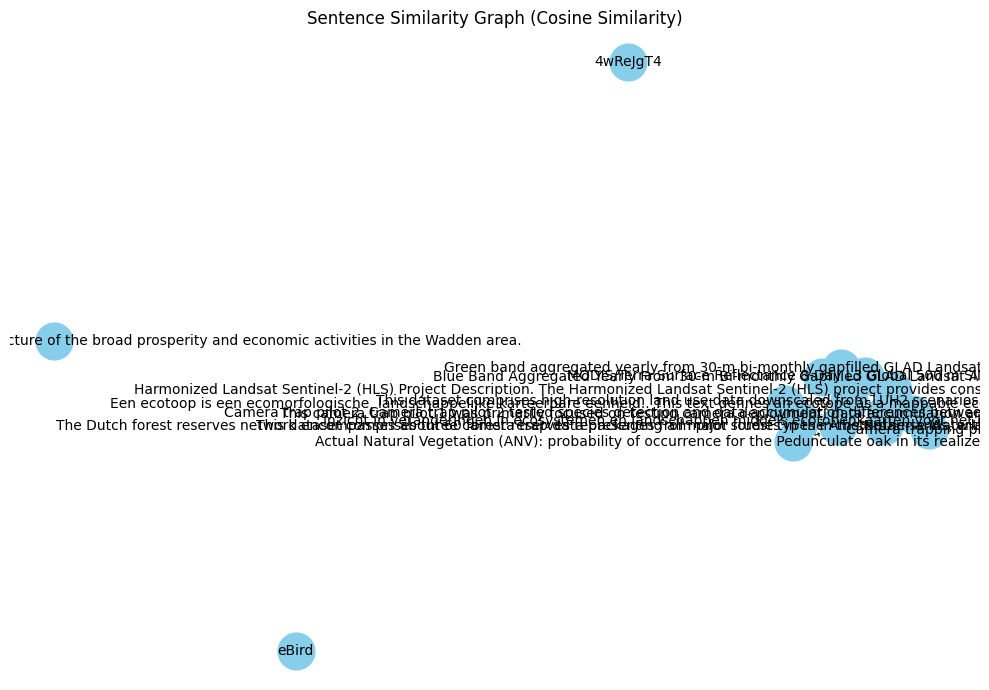

In [69]:
import networkx as nx

texts = value_list  # Use the list of values as texts for the graph

# Create graph
G = nx.Graph()

# Add nodes
for i, text in enumerate(texts):
    G.add_node(i, label=text)

# Add edges with weights (only if similarity > threshold to reduce clutter)
threshold = 0.3
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        weight = cos_sim_matrix[i, j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

# Compute layout — higher weights = stronger spring pull
# Invert similarity to distance: higher similarity = shorter distance
distances = {(i, j): 1 / cos_sim_matrix[i, j] for i, j in G.edges}
pos = nx.spring_layout(G, weight=None, k=None, scale=2, iterations=100, pos=None, fixed=None, center=None, dim=2)

# Draw nodes and edges
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*4 for u, v in G.edges], alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i: texts[i] for i in G.nodes}, font_size=10)

# Draw edge labels (similarity values)
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Sentence Similarity Graph (Cosine Similarity)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import numpy as np
import umap
# Dimensionality reduction to 2D
reduced = TSNE(n_components=2, metric='cosine', perplexity=5, random_state=42).fit_transform(embeddings)

# reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced = reducer.fit_transform(embeddings)

# Create scatter plot
fig = go.Figure()

# Add nodes
for i, (x, y) in enumerate(reduced):
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        text=[str(i)],
        textposition="top center",
        marker=dict(size=10),
        hoverinfo='text'
    ))

# Optionally: Add lines for high-similarity pairs
threshold = 0.5
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        if cos_sim_matrix[i][j] > threshold:
            fig.add_trace(go.Scatter(
                x=[reduced[i][0], reduced[j][0]],
                y=[reduced[i][1], reduced[j][1]],
                mode='lines',
                line=dict(width=cos_sim_matrix[i][j]*5, color='lightgray'),
                hoverinfo='skip'
            ))

fig.update_layout(
    title="Interactive 2D Sentence Similarity Graph (TSNE)",
    showlegend=False,
    margin=dict(l=20, r=20, t=40, b=20),
    xaxis=dict(scaleanchor='y', scaleratio=1),
    yaxis=dict(scaleanchor='x', scaleratio=1),
)
fig.show()


NameError: name 'embeddings' is not defined

# Run with Temporal coverage

In [64]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

concerned_attributes = ["Temporal coverage"]
embedding_list = []
for attr in concerned_attributes:
    value_list = []
    for url, metadata_dict in loaded_data.items():
        if attr in metadata_dict:
            if metadata_dict[attr][0] != "N/A":
                # Append the value of the concerned attribute to the list
                value_list.append(metadata_dict[attr][0])
        
value_list

['2015-11-28T00:00:00Z–2025-05-31T23:38:19Z',
 '2000-02-18 to Present',
 '2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 'Present to 2050',
 '1982-2005 (Measurements), 1983-2000 (Designation)',
 'January 1, 1800 - December 31, 2023',
 'August 13th 2021 - August 2023',
 'August 14, 2021 - September 24, 2021',
 'March 1, 2023 - March 31, 2023',
 '2021–2023',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2017',
 '2024',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2010-12-08 to 2016-11-01']

In [ ]:
from google import genai
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

client = genai.Client(
    api_key=os.getenv("GEMINI_API_KEY")
)
value_list_string = ",\n".join(value_list)

llm_model = "gemini-2.5-flash-preview-05-20"

prompt = f"""
You are an expert in data formatting. Given a list of time points or time period ranges, your task is to normalize and format them into a consistent list of strings separated by commas.

Formatting rules:

    If an item is a single year (e.g., 2000), convert it into a full date range: 2000-01-01-2000-12-31.

    If a date-time includes hours, minutes, or seconds (e.g., 2000-01-01 00:00:00 UTC), remove the time portion and keep only the date in YYYY-MM-DD format.

    If Present is includes, keep it as is.

    Otherwise express time periods as YYYY-MM-DD-YYYY-MM-DD.

    Separate all formatted periods with commas in the output.

    Do not include any additional text, code or formatting in the output, just the formatted string.

Input list:
{value_list_string}

Output:
"""

response = client.models.generate_content(
    model=llm_model,
    contents=prompt
)
response_text = response.text

'2015-11-28T00:00:00Z–2025-05-31T23:38:19Z,\n2000-02-18 to Present,\n2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC,\n2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,\nPresent to 2050,\n1982-2005 (Measurements), 1983-2000 (Designation),\nJanuary 1, 1800 - December 31, 2023,\nAugust 13th 2021 - August 2023,\nAugust 14, 2021 - September 24, 2021,\nMarch 1, 2023 - March 31, 2023,\n2021–2023,\n2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,\n2017,\n2024,\n2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,\n2010-12-08 to 2016-11-01'

In [ ]:
value_list

['2015-11-28T00:00:00Z–2025-05-31T23:38:19Z',
 '2000-02-18 to Present',
 '2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 'Present to 2050',
 '1982-2005 (Measurements), 1983-2000 (Designation)',
 'January 1, 1800 - December 31, 2023',
 'August 13th 2021 - August 2023',
 'August 14, 2021 - September 24, 2021',
 'March 1, 2023 - March 31, 2023',
 '2021–2023',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2017',
 '2024',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2010-12-08 to 2016-11-01']

In [58]:
from datetime import datetime

def split_temporal_coverage(temporal_coverages):
    temporal_coverage_list = temporal_coverages.split(",")
    ans = []
    
    for temporal_coverage in temporal_coverage_list:
        if isinstance(temporal_coverage, str):
            parts = temporal_coverage.split("-")
            if len(parts) == 6:
                start_time = datetime.strptime("-".join(parts[:3]), "%Y-%m-%d")
                end_time = datetime.strptime("-".join(parts[3:]), "%Y-%m-%d")
                
            elif len(parts) == 4:
                now = datetime.now()
                if parts[0].strip().lower() == "present":
                    start_time = now
                    end_time = datetime.strptime("-".join(parts[1:]), "%Y-%m-%d")
                elif parts[-1].strip().lower() == "present":
                    end_time = datetime.strptime("-".join(parts[:-1]), "%Y-%m-%d")
                    end_time = now
            ans.append((start_time, end_time))
    
    return ans

split_temporal_coverage(response_text)

UnboundLocalError: cannot access local variable 'start_time' where it is not associated with a value

In [61]:
response_text

'To normalize and format the given list of time points or time period ranges, we\'ll follow these steps:\n\n1.  **Reconstruct the raw input strings:** The input is provided as a list of individual characters, where `,,` indicates the separation between distinct time period entries. We need to join these characters to form the original time strings.\n2.  **Process each time period string:** Apply the formatting rules based on the content of each string.\n\nHere\'s the Python code to achieve this:\n\n```python\nimport re\nfrom datetime import datetime, timedelta\nimport calendar\n\n# The raw input provided is a sequence of characters, separated by commas.\n# We\'ll first reconstruct the actual input strings by joining these characters.\n# The delimiter between complete items is `,,` (two consecutive commas).\nraw_input_data = """2,\n0,\n1,\n5,\n-,\n1,\n1,\n-,\n2,\n8,\nT,\n0,\n0,\n:,\n0,\n0,:,\n0,\n0,\nZ,\n–,\n2,\n0,\n2,\n5,\n-,\n0,\n5,\n-,\n3,\n1,\nT,\n2,\n3,\n:,\n3,\n8,\n:,\n1,\n9,\nZ,\